## Perbandingan APBD Kabupaten/Kota Se-Jawa Timur

<p style="text-align: justify;">
APBD merupakan instrumen penting bagi Pemerintah Daerah dalam memberikan pelayanan dan meningkatkan kesejahteraan masyarakat. Oleh karena itu, memahami gambaran kinerja fiskal Kabupaten/Kota di Jawa Timur penting dilakukan untuk mengidentifikasi kemampuan tiap daerah menjalankan kewenangannya.  <br>
Analisis sederhana ini menggunakan data dengan periode 4 tahun, yakni dari tahun anggaran 2021 hingga 2024, dengan cakupan seluruh kabupaten/kota di Jawa Timur, sebanyak 38 daerah.<br>
Pemetaan APBD Kabupaten/Kota ini terbatas pada beberapa aspek antara lain: <br>
1. Clustering APBD Kabupaten/Kota; <br>
2. Perhitungan Rasio PAD terhadap PDRB; <br>
3. Pertumbuhan APBD; <br>
4. Pemetaan kapasitas fiskal tiap daerah di Jawa Timur; <br>
5. Pemetaan Belanja Pegawai, khususnya dalam konteks penerapan Pasal 147 ayat (1) UU No. 1 Tahun 2022 tentang HKPD. <br>
Analisa sederhana ini dilakukan menggunakan Python sebagai alat analisis dan penyajian data. <br>

Sumber data APBD diperoleh dari [Portal SIKD Kementrian Keuangan](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38)<br>
Sumber data PDRB diperoleh dari [Portal BPS](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38)
</p>

### A. Persiapan Data
<p style="text-align: justify;">
Langkah pertama sebelum menggunakan Python sebagai alat bantu adalah setup awal dan install modul/library yang dibutuhkan. Untuk menjaga konsistensi antar file, kita cantumkan nama daerah dan kode rekening ke dalam array dan menetapkan root directory (folder sumber) sebagai lokasi sumber file APBD tersimpan.
</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import geopandas as gpd

# Constants
NAMA_DAERAH = [
    "Bangkalan", "Banyuwangi", "Batu", "Blitar", "Bojonegoro", "Bondowoso",
    "Gresik", "Jember", "Jombang", "Kediri", "Kota_Blitar", "Kota_Kediri",
    "Kota_Madiun", "Kota_Malang", "Kota_Mojokerto", "Kota_Pasuruan", 
    "Kota_Probolinggo", "Lamongan", "Lumajang", "Madiun", "Magetan", "Malang", 
    "Mojokerto", "Nganjuk", "Ngawi", "Pacitan", "Pamekasan", "Pasuruan", 
    "Ponorogo", "Probolinggo", "Sampang", "Sidoarjo", "Situbondo", "Sumenep", 
    "Surabaya", "Trenggalek", "Tuban", "Tulungagung"
]

REKENING = [
    "Pendapatan Daerah", "PAD", "Pajak Daerah", "Retribusi Daerah", 
    "Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan", "Lain-Lain PAD yang Sah", 
    "TKDD", "Pendapatan Transfer Pemerintah Pusat", "Pendapatan Lainnya", 
    "Belanja Daerah", "Belanja Operasi", "Belanja Modal", 
    "Belanja Tidak Terduga", "Pembiayaan Daerah", 
    "Penerimaan Pembiayaan Daerah", "Pengeluaran Pembiayaan Daerah"
]

ROOT_DIR = Path(r'E:\Project\GH\APBDKabJatim\data\apbd')

Data APBD yang didapat dari [Portal SIKD Kemenkeu](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38) merupakan himpunan data berformat `.CSV`dengan pola penamaan `kabupaten/kota.csv`. File APBD ini tersimpan dalam direktori 'data' sebagai folder utama. Pada direktori utama ini kemudian tersimpan beberapa subfolder untuk menyimpan data APBD sesuai tahun anggaran. <br>
Selanjutnya kita satukan seluruh data APBD yang tersebar dalam subfolder dan folder utama ini menjadi satu dataframe dan dilanjutkan dengan cleaning data. 


In [3]:
def read_csv_files(root_dir):
    data = []
    for folder_tahun in root_dir.iterdir():
        if folder_tahun.is_dir():
            for file in folder_tahun.glob('*.csv'):
                try:
                    df = pd.read_csv(file)
                    df['Tahun'] = folder_tahun.name
                    df['Daerah'] = file.stem
                    data.append(df)
                except Exception as e:
                    print(f"Error membuka {file.name}: {str(e)}")
    
    if not data:
        raise ValueError("File CSV tidak ditemukan atau tidak dapat terbaca.")
    
    return pd.concat(data, ignore_index=True)

def clean_data(df):
    def convert_to_float(value):
        if isinstance(value, str):
            value = value.replace('M', '').strip()
            if '.' in value and ',' in value:
                value = value.replace('.', '').replace(',', '.')
            elif ',' in value:
                value = value.replace(',', '.')
            value = re.sub(r'[^\d.]', '', value)
        return float(value) if value else 0.0

    for col in ['anggaran', 'realisasi', 'persentase']:
        df[col] = df[col].apply(convert_to_float)
    return df

def match_category(category, valid_categories):
    return next((vc for vc in valid_categories if category.lower() in vc.lower()), None)

def process_budget_data(root_dir, selected_categories=None):
    df = read_csv_files(root_dir)
    df = clean_data(df)
    
    latest_year = df['Tahun'].max()
    df = df[df['Tahun'] == latest_year]
    
    df = df.groupby(['akun', 'Daerah'])['anggaran'].sum().reset_index()
    df_pivot = df.pivot(index='Daerah', columns='akun', values='anggaran')
    
    for region in NAMA_DAERAH:
        if region not in df_pivot.index:
            df_pivot.loc[region] = 0
    
    df_pivot = df_pivot.loc[NAMA_DAERAH].fillna(0)
    
    if selected_categories:
        matched_categories = [match_category(cat, df_pivot.columns) for cat in selected_categories]
        matched_categories = [cat for cat in matched_categories if cat is not None]
        
        if not matched_categories:
            print("Peringatan: Tidak ada kategori yang cocok. Menampilkan semua kategori yang tersedia.")
            print(f"Kategori yang tersedia: {', '.join(df_pivot.columns)}")
        else:
            df_pivot = df_pivot[matched_categories]
            missing_categories = set(selected_categories) - set(matched_categories)
            if missing_categories:
                print(f"Peringatan: Kategori berikut tidak ditemukan dalam data: {', '.join(missing_categories)}")
    
    return df_pivot

Setelah seluruh data disatukan dalam satu dataframe, selanjutnya kita cek apakah dataframe yang telah terbentuk mengakomodir seluruh data APBD yang tersedia.

In [4]:
def process_budget_data(root_dir, selected_categories=None):
    df = read_csv_files(root_dir)
    df = clean_data(df)
    
    latest_year = df['Tahun'].max()
    df = df[df['Tahun'] == latest_year]
    
    df = df.groupby(['akun', 'Daerah'])['anggaran'].sum().reset_index()
    df_pivot = df.pivot(index='Daerah', columns='akun', values='anggaran')
    
    for region in NAMA_DAERAH:
        if region not in df_pivot.index:
            df_pivot.loc[region] = 0
    
    df_pivot = df_pivot.loc[NAMA_DAERAH].fillna(0)
    
    if selected_categories:
        available_categories = df_pivot.columns.tolist()
        print(f"Available categories: {', '.join(available_categories)}")
        
        matched_categories = []
        for cat in selected_categories:
            matched = match_category(cat, available_categories)
            if matched:
                matched_categories.append(matched)
            else:
                print(f"Warning: Category '{cat}' not found in data.")
        
        if not matched_categories:
            print("No matching categories found. Using all available categories.")
        else:
            df_pivot = df_pivot[matched_categories]
            print(f"Using categories: {', '.join(matched_categories)}")
    
    return df_pivot

def match_category(category, valid_categories):
    lowercase_category = category.lower()
    for valid_cat in valid_categories:
        if lowercase_category in valid_cat.lower():
            return valid_cat
    return None

# Usage
kategori_anggaran = [
    "Pendapatan Daerah",
    "Belanja Daerah",
    "Pembiayaan Daerah"
]
result_df = process_budget_data(ROOT_DIR, kategori_anggaran)
print(result_df)

Available categories:  Belanja Bagi Hasil,  Belanja Bantuan Keuangan,  Belanja Bantuan Sosial,  Belanja Barang dan Jasa,  Belanja Bunga,  Belanja Daerah,  Belanja Hibah,  Belanja Lainnya,  Belanja Modal,  Belanja Pegawai,  Belanja Subsidi,  Belanja Tidak Terduga,  Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan,  Lain-Lain PAD yang Sah,  Lain-lain Pendapatan Sesuai dengan Ketentuan Peraturan Perundang-Undangan,  PAD,  Pajak Daerah,  Pembayaran Cicilan Pokok Utang yang Jatuh Tempo,  Pembentukan Dana Cadangan,  Pembiayaan Daerah,  Pencairan Dana Cadangan,  Pendapatan Daerah,  Pendapatan Hibah,  Pendapatan Lainnya,  Pendapatan Transfer Antar Daerah,  Pendapatan Transfer Pemerintah Pusat,  Penerimaan Kembali Pemberian Pinjaman Daerah,  Penerimaan Pembiayaan Daerah,  Penerimaan Pinjaman Daerah,  Pengeluaran Pembiayaan Daerah,  Pengeluaran Pembiayaan Lainnya Sesuai dengan Ketentuan Peraturan Perundang-Undangan,  Penyertaan Modal Daerah,  Retribusi Daerah,  Sisa Lebih Perhitungan Anggaran T

### B. Visualisasi Data
<p style="text-align: justify;">
Untuk lebih memberikan gambaran dataframe, kita visualisasikan data APBD antar daerah untuk tahun anggaran 2024
</p>

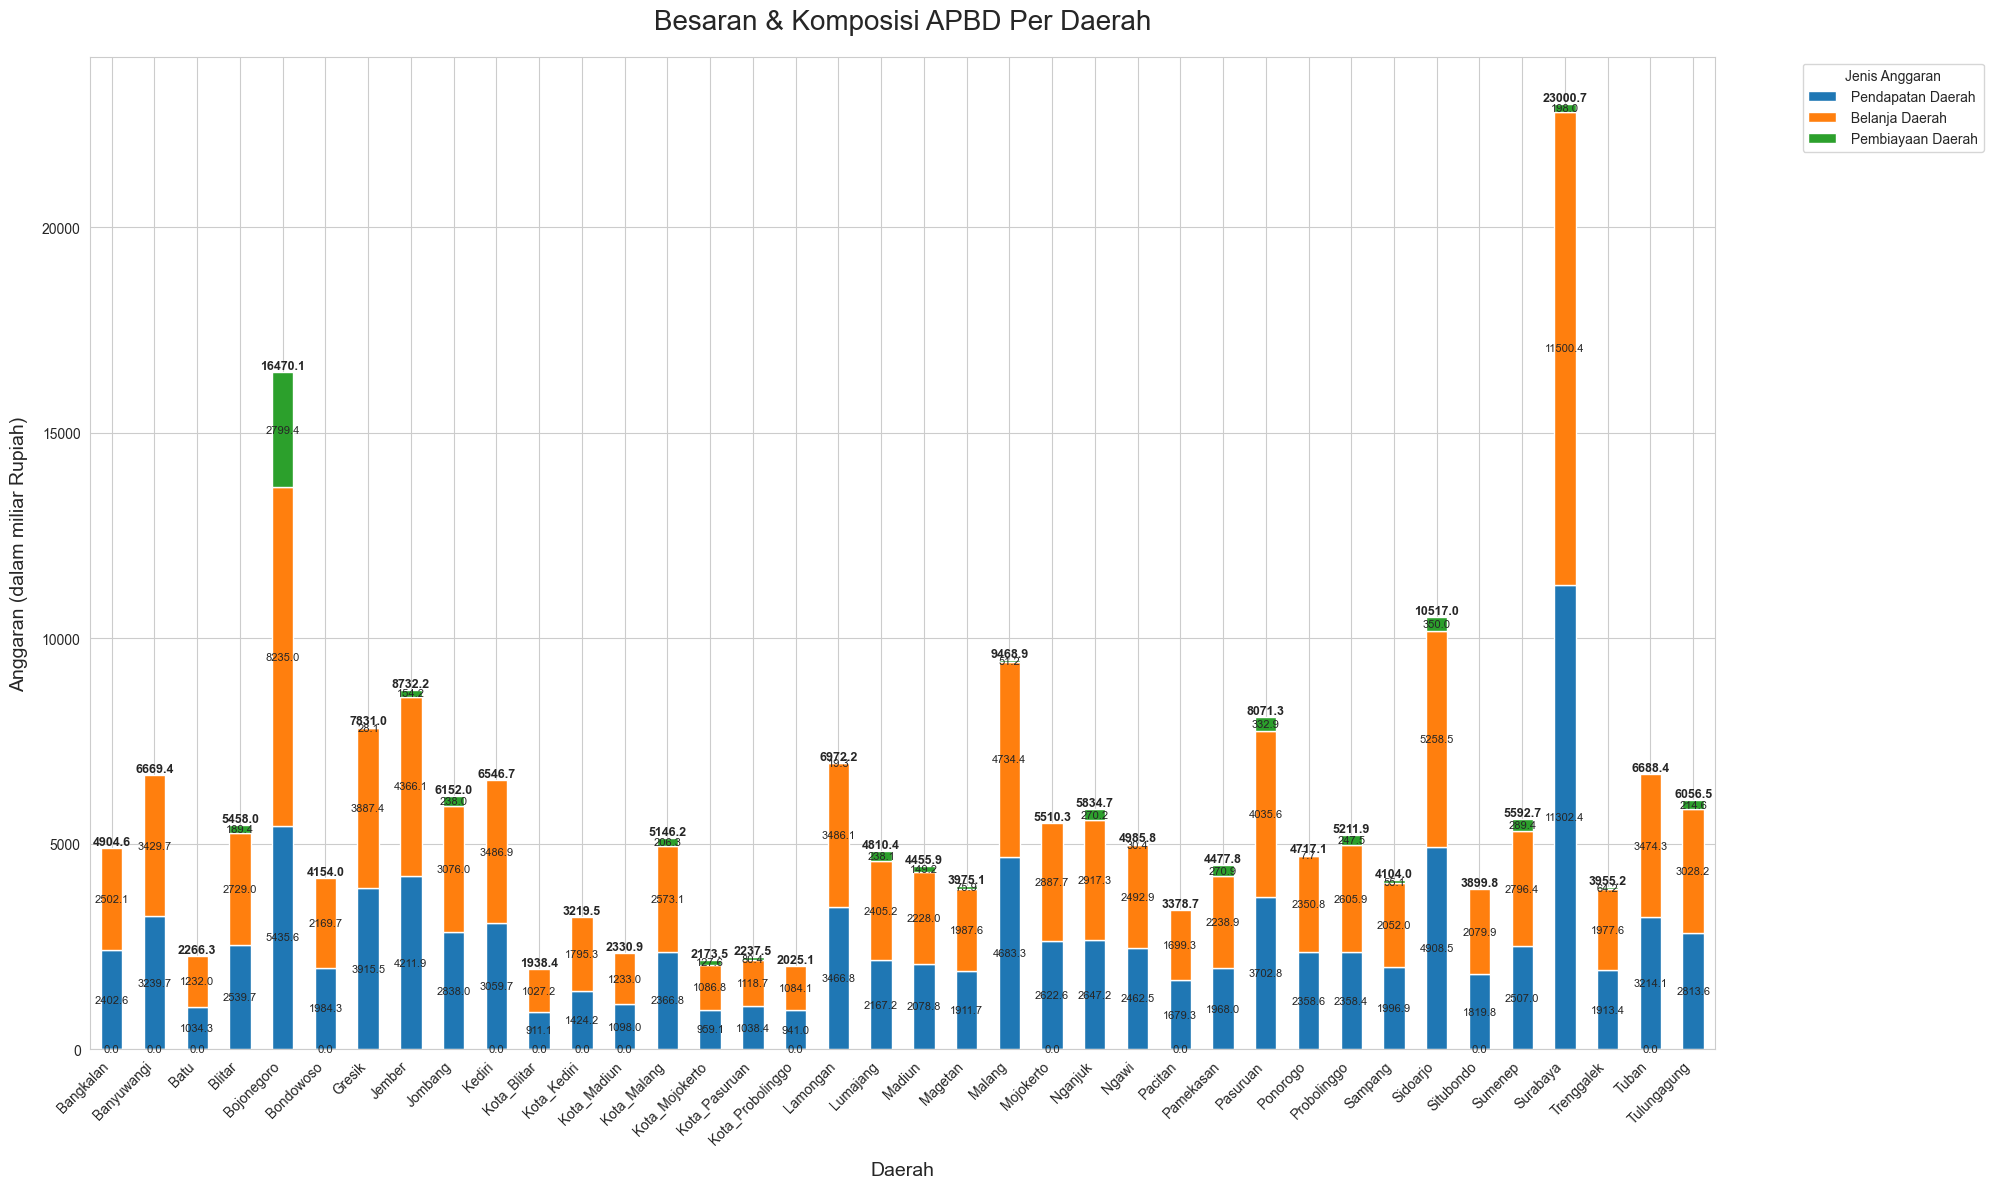

In [5]:
def visualize_budget_data(df, title='Besaran & Komposisi APBD Per Daerah', figsize=(20, 12)):
    # Set the style
    sns.set_style("whitegrid")
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the stacked bar chart
    df.plot(kind='bar', stacked=True, ax=ax)
    
    # Customize the plot
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel('Daerah', fontsize=14, labelpad=10)
    plt.ylabel('Anggaran (dalam miliar Rupiah)', fontsize=14, labelpad=10)
    
    # Rotate x-axis labels and adjust their position
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # Adjust legend
    plt.legend(title='Jenis Anggaran', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Add value labels on the bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', label_type='center', fontsize=8)
    
    # Add total value on top of each stack
    for i, total in enumerate(df.sum(axis=1)):
        ax.text(i, total, f'{total:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


visualize_budget_data(result_df)

### C. Clustering data APBD
<p style="text-align: justify;">
Clustering menggunakan K-Means berdasarkan anggaran.
</p>

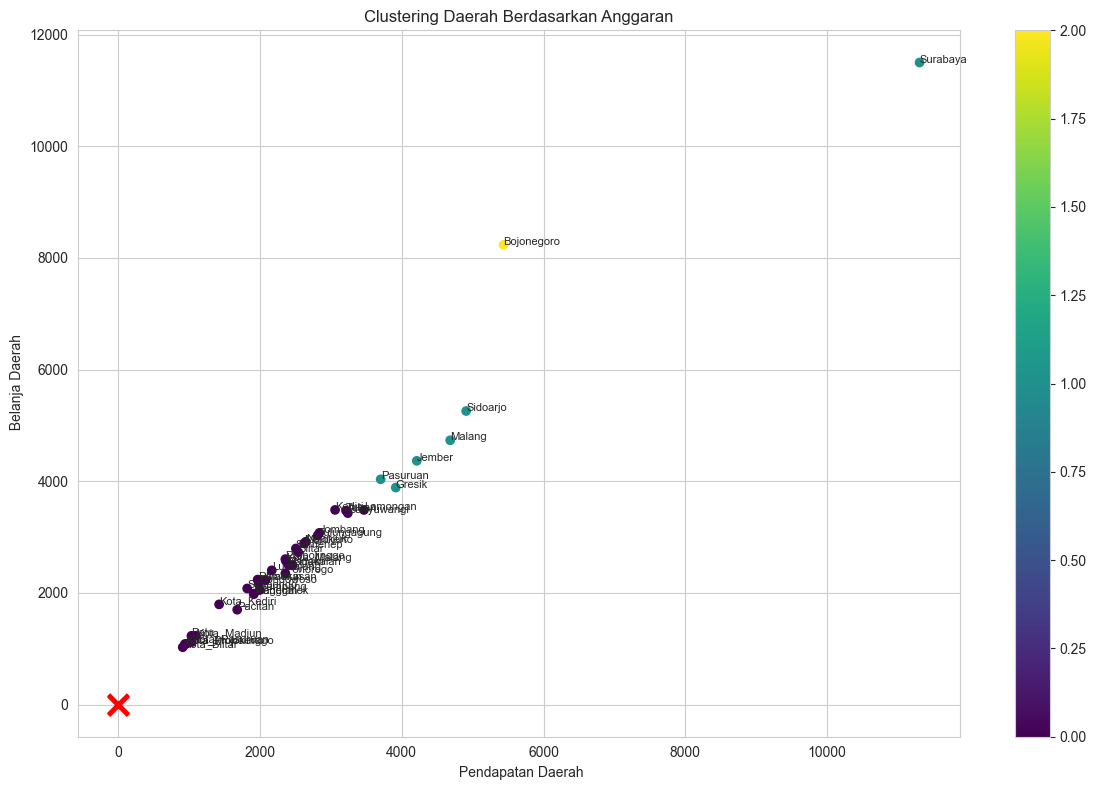


Hasil Clustering:
akun              Cluster   Pendapatan Daerah   Belanja Daerah  \
Daerah                                                           
Bangkalan               0             2402.58          2502.06   
Banyuwangi              0             3239.71          3429.71   
Batu                    0             1034.32          1231.96   
Blitar                  0             2539.66          2729.02   
Bojonegoro              2             5435.62          8235.03   
Bondowoso               0             1984.27          2169.74   
Gresik                  1             3915.51          3887.41   
Jember                  1             4211.89          4366.08   
Jombang                 0             2838.00          3076.00   
Kediri                  0             3059.74          3486.92   
Kota_Blitar             0              911.13          1027.24   
Kota_Kediri             0             1424.24          1795.30   
Kota_Madiun             0             1097.97          12

In [9]:
def visualize_clusters(df, centers):
    plt.figure(figsize=(12, 8))
    
    categories = df.columns[:2]
    
    scatter = plt.scatter(df[categories[0]], df[categories[1]], c=df['Cluster'], cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
    
    plt.title('Clustering Daerah Berdasarkan Anggaran')
    plt.xlabel(categories[0])
    plt.ylabel(categories[1])
    plt.colorbar(scatter)
    
    for i, txt in enumerate(df.index):
        plt.annotate(txt, (df[categories[0]].iloc[i], df[categories[1]].iloc[i]), fontsize=8)
    
    plt.tight_layout()
    plt.show()

def perform_clustering(df, n_clusters=3):
    X = df.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    df['Cluster'] = cluster_labels

    return df, kmeans.cluster_centers_

# Usage
clustered_df, cluster_centers = perform_clustering(result_df)

visualize_clusters(clustered_df, cluster_centers)

print("\nHasil Clustering:")
print(clustered_df[['Cluster'] + list(result_df.columns)])

for cluster in range(clustered_df['Cluster'].nunique()):
    print(f"\nDaerah dalam Cluster {cluster}:")
    print(clustered_df[clustered_df['Cluster'] == cluster].index.tolist())
    print(f"Karakteristik Cluster {cluster}:")
    print(clustered_df[clustered_df['Cluster'] == cluster].mean())

Time Series Analysis

In [10]:
def plot_correlation(df):
    corr = df[['Pendapatan Daerah', 'PAD', 'TKDD', 'Belanja Daerah']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation between Budget Components')
    plt.show()

plot_correlation(df)

NameError: name 'df' is not defined

In [ ]:
# Convert numeric columns to float
numeric_columns = ['anggaran', 'realisasi', 'persentase']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert 'Tahun' to datetime
df['Tahun'] = pd.to_datetime(df['Tahun'].str.replace('apbd_', ''), format='%Y')

# Pivot the data to have akun as columns
df_pivot = df.pivot_table(values='anggaran', index=['Daerah', 'Tahun'], columns='akun', aggfunc='first').reset_index()

print(df_pivot.head())
print(df_pivot.columns)